# Introduction
---

The goal of this code is to integrate segmentation models, specifically the Segment Anything Model 2 (SAM2), with a Bayesian Convolutional Neural Network (BCNN) with Monte Carlo Dropout for medical image analysis. This approach leverages the power of SAM2 for generating high-quality image segmentations, which are then used as input to the BCNN for classification and uncertainty estimation. The code is applied currently to a chest X-ray dataset to demonstrate its potential in medical diagnosis and decision-making (will add brain datasets for comparison with the chest x-rays as well as other models).

## Setting Up Environment

 *Used google colab to run this code*

In [1]:
!git clone https://github.com/DumplingCodeEater/SAM-with-BCNN.git

Cloning into 'SAM-with-BCNN'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 72 (delta 3), reused 30 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 28.25 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
%ls
%cd SAM-with-BCNN

sample_data/  SAM-with-BCNN/
/content/SAM-with-BCNN


In [2]:
!nvidia-smi

Sun Oct 13 22:13:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# To ensure python 3.12 is used (anything over 3.10 is fine in order for SAM2 to run)
# If not using google colab or any other environment that preinstalls latest python
# Creates a `myenv`` virtual environment (as shown in the folder)
# Ex: These are windows commands:
# !py -3.12 -m venv myenv
# !myenv\Scripts\activate
# !py --version

In [8]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content/SAM-with-BCNN


In [ ]:
# Installing SAM2 (Reference: https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb#scrollTo=nx8UNmABNkJP)

# Clone and install SAM2 from Meta's repository
# Might take some time
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 967, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 967 (delta 14), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (967/967), 128.94 MiB | 33.58 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/SAM-with-BCNN/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 

In [6]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 38.8 MB/s eta 0:00:00


**NOTE**: SAM2 is available in 4 different model sizes, as imported below

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Importing

In [10]:
# Importing Necessary Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random
import cv2
import base64
import supervision as sv

# Importing SAM2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator


# # Dataset Links
# CHEST_XRAY_DATASET_URL = "https://paperswithcode.com/dataset/chestx-ray14"
# BRAIN_MRI_DATASET_URL = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10584795/"

# For Bayesian layers
from torch.nn.functional import dropout
from torch.distributions import Normal

**NOTE:** This code enables mixed-precision computing for faster deep learning  (bfloat16 and TensorFloat-32 (TF32)).

In [11]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Loading in a SAM2 model
**Note**: Can choose between the 4 models

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt" # Choosing the large model
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

Tuneable parameters for advanced mask generation:
- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

### Testing SAM2 on a single chest image from the chest x-ray dataset

In [ ]:
IMAGE_PATH = f"{HOME}/extracted_images/test/00007046_012.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Output format example

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
sam2_result = mask_generator.generate(image_rgb)

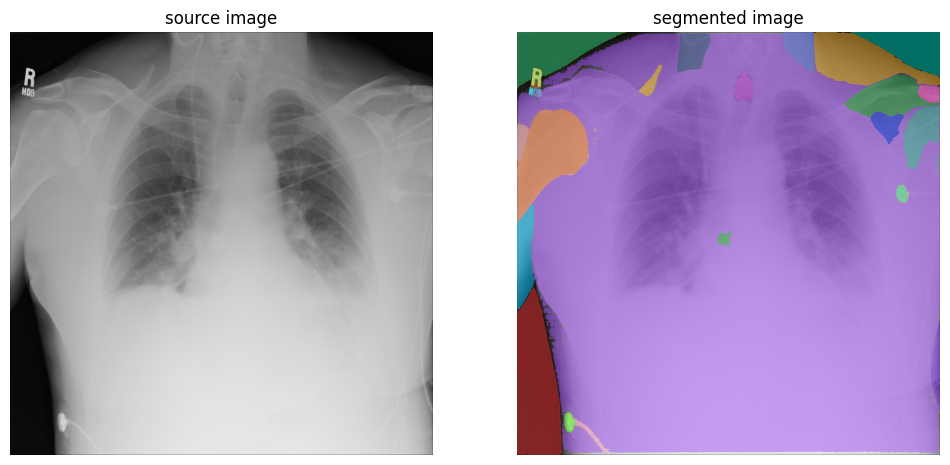

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

*Note:* this could get better segmentation if using way smaller bounding boxes and ***edge filters*** and/or perform better on some other part of the body like the brain (where parts are bigger in the images to discern)

# Getting Started with the Medical Dataset

In [ ]:
# Modify the mask_generator here
mask_generator = SAM2AutomaticMaskGenerator(model=sam2_model)

In [ ]:
# Function to generate and annotate images
def annotate_image(image_path, output_path):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate SAM2 mask results
    sam2_result = mask_generator.generate(image_rgb)

    # Annotate the image with masks
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    detections = sv.Detections.from_sam(sam_result=sam2_result)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Save the annotated image
    cv2.imwrite(output_path, annotated_image)
    print(f"Annotated image saved to {output_path}")

In [ ]:
IMAGE_DIRS = ['test', 'train', 'val']
ANNOTATED_DIR = f"{HOME}/annotated_images"
# Iterate over all images in test, train, and val folders and annotate them
for image_dir in IMAGE_DIRS:
    extracted_dir = os.path.join(HOME, "extracted_images", image_dir)
    annotated_dir = os.path.join(ANNOTATED_DIR, image_dir)
    os.makedirs(annotated_dir, exist_ok=True)

    for image_name in os.listdir(extracted_dir):
        image_path = os.path.join(extracted_dir, image_name)
        output_path = os.path.join(annotated_dir, image_name)

        # Annotate and save the result
        annotate_image(image_path, output_path)

Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00009218_007.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00008566_005.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00007417_005.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00007046_012.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/test/00007828_000.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00008468_031.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00008067_009.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00008151_001.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00007408_001.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00007245_002.png
Annotated image saved to /content/SAM-with-BCNN/annotated_images/train/00006774_007.png
Annotated image saved to /content/SAM

In [ ]:
# Checkpoint:
# Zips the current directory and right click and press Download via files
# PATH: /content/SAM-with-BCNN.zip
!zip -r annotated_images.zip annotated_images/

updating: annotated_images/ (stored 0%)
updating: annotated_images/train/ (stored 0%)
updating: annotated_images/train/00008468_031.png (deflated 22%)
updating: annotated_images/train/00008067_009.png (deflated 26%)
updating: annotated_images/train/00008151_001.png (deflated 22%)
updating: annotated_images/train/00007408_001.png (deflated 23%)
updating: annotated_images/train/00007245_002.png (deflated 26%)
updating: annotated_images/train/00006774_007.png (deflated 22%)
updating: annotated_images/train/00007157_001.png (deflated 10%)
updating: annotated_images/train/00008922_008.png (deflated 22%)
updating: annotated_images/train/00007747_001.png (deflated 24%)
updating: annotated_images/train/00008411_005.png (deflated 24%)
updating: annotated_images/test/ (stored 0%)
updating: annotated_images/test/00009218_007.png (deflated 24%)
updating: annotated_images/test/00008566_005.png (deflated 26%)
updating: annotated_images/test/00007417_005.png (deflated 21%)
updating: annotated_images/

# Running a BCNN (Bayesian Convolution Neural Network)

- Uses a pretrained DenseNet
- Integrates Monte Carlo Dropout for Measuring Uncertainty
-*Note*: AUC-ROC is not calculable since there are cases where there are only negative or only positive samples in the true labels, suggesting the model might need to be trained on some more data.
- It also seems like the values are close to 0.5, thus the model might need to be trained for a longer period of time in order to learn the distinctions.
- Will remove outputs like the probabilities outputs from the  after fine-tuning

In [12]:
from torchvision.models import DenseNet121_Weights

In [31]:
# Data Preprocessing
class ChestXrayAnnotatedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        # List of all possible labels, including "No Finding"
        self.labels_list = ["No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
                            "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation",
                            "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
        # Filter the dataframe to keep only images present in the img_dir
        self.dataframe = self.dataframe[self.dataframe['Image Index'].isin(os.listdir(img_dir))]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        # Get the image file observation from the .csv file
        img_name = self.dataframe.iloc[idx]['Image Index']
        img_path = os.path.join(self.img_dir, img_name)

        # Get the labels for the image
        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.iloc[idx]['Finding Labels'].split('|')
        label_tensor = torch.zeros(len(self.labels_list))

        # Create one-hot encoding for labels
        if "No Finding" in labels:
            label_tensor[0] = 1  # Set "No Finding" to 1
        else:
            for label in labels:
                if label in self.labels_list:
                    label_tensor[self.labels_list.index(label)] = 1

        if self.transform:
            image = self.transform(image)
        return image, label_tensor

    def iterate_data(self):
        for idx in range(len(self.dataframe)):
            yield self.__getitem__(idx)


# Model Implementation of BCNN
class BCNN_Model(nn.Module):
    def __init__(self):
        super(BCNN_Model, self).__init__()
        # Using DenseNet as the CNN backbone
        self.backbone = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity()

        # Layers
        self.fc1 = nn.Linear(1024, 512)
        #self.fc2 = nn.Linear(512, 2)  # Binary classification (Disease vs No Disease)
        self.fc2 = nn.Linear(512, 15)  # Multi-label classification (15 classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Uncertainty Estimation using Monte Carlo Dropout
def mc_dropout(model, images, n_samples=10):
    model.train()  # Enable dropout at inference
    images = images.half() # float 16
    preds = [model(images) for _ in range(n_samples)]
    return torch.stack(preds).mean(0), torch.stack(preds).std(0)

In [44]:
# Training the Model
def train_model(model, train_loader, val_loader, num_epochs=20):

    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            labels = labels.to(device).float()
            outputs = model(inputs.to(device).float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    return model

# Evaluation Metrics with Validation Set
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            preds = model(inputs).to(torch.float32)

            # Convert predictions to probabilities using sigmoid activation
            preds = torch.sigmoid(preds)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    print("Predictions on validation set", all_preds)
    # Apply a threshold to get binary predictions for each class
    all_preds = (np.array(all_preds) > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print("Validation check:")
    for i in range(all_labels.shape[1]):  # Assuming multi-label with shape (num_samples, num_classes)
        print(f"Class {i}:")
        print(f"  True labels: {np.sum(all_labels[:, i])} positives, \
        {np.sum(1 - all_labels[:, i])} negatives")
        print(f"  Predicted labels: {np.sum(all_preds[:, i])} positives, \
        {np.sum(1 - all_preds[:, i])} negatives")

    # Attempt to calculate AUC-ROC score (due to cases of small batches)
    try:
        auc_roc = roc_auc_score(all_labels, all_preds, average='weighted')
    except ValueError:
        auc_roc = None  # Handle the case where AUC cannot be computed

    # Print the evaluation metrics
    print(f"Val-Accuracy: {accuracy:.4f}, Val-Precision: {precision:.4f}, "
          f"Val-Recall: {recall:.4f}, Val-F1-Score: {f1:.4f}, "
          f"AUC-ROC: {auc_roc:.4f}" if auc_roc is not None else f"AUC-ROC: Not calculable")

In [45]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Transformer
image_size = 224 # Common number for DenseNet121
data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),

    # just some random numbers for now: (might need to make function to find mean)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the training and validation datasets
df = pd.read_csv(f"{HOME}/Data_Entry_2017_v2020.csv")
train_dataset = ChestXrayAnnotatedDataset(dataframe=df, img_dir=f"{HOME}/annotated_images/train", transform=data_transform)
val_dataset = ChestXrayAnnotatedDataset(dataframe=df, img_dir=f"{HOME}/annotated_images/val", transform=data_transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


# Initialize the model
model = BCNN_Model().to(device).float()

# Train the model
trained_model = train_model(model, train_loader, val_loader)

# Evaluate the trained model
evaluate_model(trained_model, val_loader)

# Load test data (no labels)
test_dataset = ChestXrayAnnotatedDataset(dataframe=df,img_dir=f"{HOME}/annotated_images/test", transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Evaluate the trained model
evaluate_model(trained_model, test_loader)

# Uncertainty Estimation on test data using Monte Carlo Dropout
test_images, _ = next(iter(test_loader))
mean_preds, uncertainty = mc_dropout(trained_model, test_images.to(device))
print(f"Test Mean predictions: {mean_preds}, Uncertainty: {uncertainty}")

Epoch [1/20], Loss: 3.246875047683716
Epoch [2/20], Loss: 3.1156251430511475
Epoch [3/20], Loss: 2.995312452316284
Epoch [4/20], Loss: 3.018749952316284
Epoch [5/20], Loss: 2.8125
Epoch [6/20], Loss: 2.882031202316284
Epoch [7/20], Loss: 2.719531297683716
Epoch [8/20], Loss: 2.66015625
Epoch [9/20], Loss: 2.516406297683716
Epoch [10/20], Loss: 2.5843751430511475
Epoch [11/20], Loss: 2.5726563930511475
Epoch [12/20], Loss: 2.495312452316284
Epoch [13/20], Loss: 2.532031297683716
Epoch [14/20], Loss: 2.4281251430511475
Epoch [15/20], Loss: 2.4468750953674316
Epoch [16/20], Loss: 2.3335938453674316
Epoch [17/20], Loss: 2.2632813453674316
Epoch [18/20], Loss: 2.2734375
Epoch [19/20], Loss: 2.23828125
Epoch [20/20], Loss: 2.1953125
Predictions on validation set [[0.46004632 0.46198753 0.43782353 0.46101677 0.5131196  0.495514
  0.4359015  0.45350388 0.56505877 0.4970856  0.4666025  0.5172051
  0.5093983  0.41774645 0.4696419 ]
 [0.4994354  0.5002394  0.4395068  0.46174484 0.5532639  0.45132

###**Explanation**:

*Shape and Content:*

This tensor has dimensions
(
5
,
15
)
(5,15) in this example, where 5 corresponds to the number of test images and 15 represents the number of classes.
Each entry represents the predicted value (logit) for each class. Since the model likely outputs logits (raw scores), these values can be both positive and negative.

*Interpretation:*

- Positive Values: Suggest a higher likelihood that the corresponding class is present.

- Negative Values: Suggest a lower likelihood or absence of the class.


In [46]:
# Assuming mean_preds is obtained from mc_dropout and is in logit form
mean_preds = torch.sigmoid(mean_preds) # Apply sigmoid function to convert logits into probabilities

# Convert probabilities to binary predictions (0 or 1 for class being present or not)
binary_preds = (mean_preds > 0.5).int()  # Use threshold to get binary predictions

In [47]:
print(f"Mean preds: {mean_preds}")
print(f"Binary preds: {binary_preds}")

Mean preds: tensor([[0.4473, 0.4453, 0.4492, 0.4883, 0.5273, 0.4570, 0.3926, 0.4980, 0.5312,
         0.4668, 0.4922, 0.5352, 0.5039, 0.4023, 0.4238],
        [0.4648, 0.4609, 0.4258, 0.4961, 0.4863, 0.4805, 0.4141, 0.4746, 0.5820,
         0.5000, 0.4727, 0.4922, 0.4707, 0.4473, 0.4844],
        [0.4609, 0.4629, 0.4668, 0.4922, 0.4902, 0.4297, 0.3770, 0.4688, 0.5117,
         0.4844, 0.5391, 0.5625, 0.4629, 0.4316, 0.4395],
        [0.4922, 0.4824, 0.4668, 0.5117, 0.4707, 0.5156, 0.3984, 0.5117, 0.5781,
         0.5195, 0.4648, 0.5117, 0.4824, 0.4336, 0.4531],
        [0.4980, 0.4590, 0.4473, 0.4648, 0.5273, 0.4785, 0.4297, 0.4922, 0.5781,
         0.4902, 0.4922, 0.5000, 0.5039, 0.4121, 0.4707]], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<SigmoidBackward0>)
Binary preds: tensor([[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 

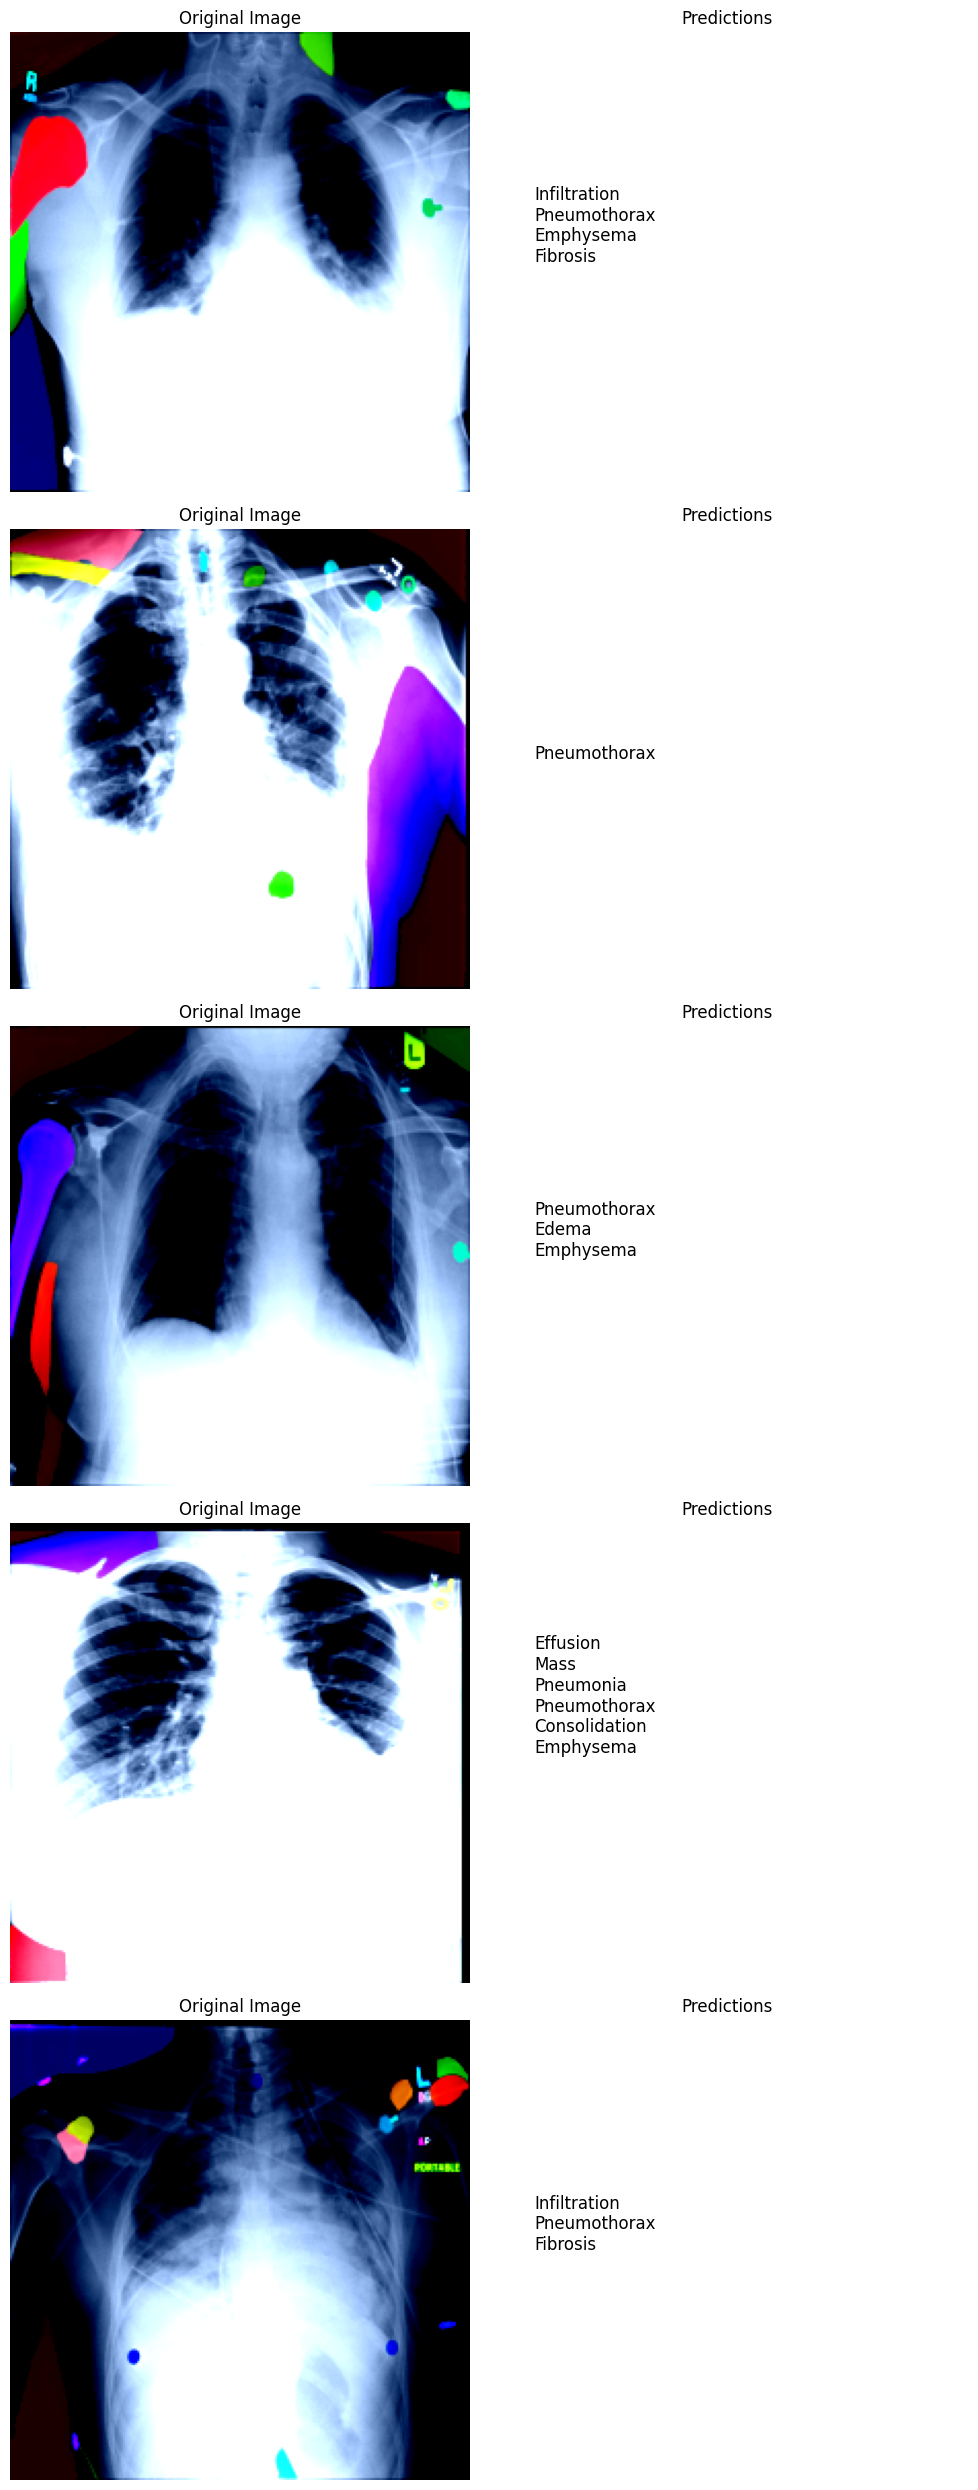

In [50]:
# Extract images and file paths from the test_loader
test_images, true_labels = [], []

for images, labels in test_loader:
    # Collect images
    test_images.append(images)  # Append the tensor of images
    true_labels.append(labels)  # Collect corresponding file paths

# Concatenate the list of tensors into one tensor
test_images = torch.cat(test_images, dim=0)  # Combine all image batches

# Assumes binary_preds (from last line) corresponds to the predictions for the test images
# Binary_preds/predictions should be aligned with the same order as test_images
def display_predictions_with_images(images, predictions, labels_list):

    num_images = images.shape[0]
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    for i in range(num_images):
        # Display original image
        image = images[i].permute(1, 2, 0).numpy()
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original Image")

        # Display predictions
        predicted_labels = [labels_list[j] for j in range(len(predictions[i])) if predictions[i, j] == 1]
        axes[i, 1].axis('off')
        axes[i, 1].text(0.1, 0.5, "\n".join(predicted_labels) if predicted_labels else "No Predictions", fontsize=12)
        axes[i, 1].set_title("Predictions")

    plt.tight_layout()
    plt.show()

# Call the function with images and predictions
display_predictions_with_images(test_images, binary_preds, test_dataset.labels_list)

- Might need to perform some other image processing techniques for better performance as some images appear to be too bright (possibly making it difficult for the model to make predictions)

Citations:
```
@inproceedings{Wang_2017,
	doi = {10.1109/cvpr.2017.369},
	url = {https://doi.org/10.1109%2Fcvpr.2017.369},
	year = 2017,
	month = {jul},
	publisher = {{IEEE}
},
	author = {Xiaosong Wang and Yifan Peng and Le Lu and Zhiyong Lu and Mohammadhadi Bagheri and Ronald M. Summers},
	title = {{ChestX}-Ray8: Hospital-Scale Chest X-Ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases},
	booktitle = {2017 {IEEE} Conference on Computer Vision and Pattern Recognition ({CVPR})}
}
```